In [6]:
import sys
sys.path.append('./PRML/')
%load_ext autoreload
%autoreload 1
%aimport LinearRegression
import LinearRegression as LR
import distance
from helper import MoorePenroseInv

import pandas as pd

import numpy as np
from numpy import polynomial as poly

from matplotlib import pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
'''
In this notebook, we will simulate some experiments introduced in Chapter 3. Along with that, we
will implement a module called LieanrRegression. As the book did, we try different method to 
train a good fitter that fits our simple *sin(x) dataset*.
First, we draw some datasets from sin(x) with some noise.
'''

# for i in range(20):
#     data = LR.simpleDataset(low=0, high=2*np.pi, precision=5, size=200)
#     data.to_csv('./dataset/sin/sinLarge.csv'.format(i+1), index=False)
#data = LR.simpleDataset(low=0, high=2*np.pi, precision=5, size=200)
#data.to_csv('./dataset/sin/sinLarge.csv', index=False)

data = pd.read_csv('./dataset/sin/sinLarge.csv')
x = np.arange(0, 2*np.pi, 0.01)
y = np.sin(x)
_x = data.iloc[:, 0].tolist()
_x = np.array(_x)
_y = data.iloc[:, 1].tolist()
_y = np.array(_y)

As explained, in order to fit the regression function parameters, there are several methods.
The first method is MLE(Maximum Likelihood Estimator), it requires our manually chosen basis functions, 
and the *Design Matrix*:

$$
\Phi = 
\left(
\begin{array}{}
\phi_0(x_1) & \phi_1(x_1) & ... \phi_{M-1}(x_1)\\
\phi_0(x_2) & \phi_1(x_2) & ... \phi_{M-1}(x_2)\\
... & ... & ... \\
\phi_0(x_N) & \phi_1(x_N) & ... \phi_{M-1}(x_N)\\
\end{array}
\right)
$$

After that, by set the gradient of *log-likelihood*, we attain the parameter:

$$
\mathbf{w}_{ML} = (\mathbf{\Phi}^T\mathbf{\Phi})^{-1}\Phi^T\mathbf{t}
\tag{3.18}
$$

Initially, we use the *polynomial* as basis functions, i.e., $\phi_i(x)=x^i, i \in {0, 1, ..., M-1}$.
In our python module, function *designMatrixGenerate* does this for us by passing @basis='poly'.

In [8]:
'''
In this block, we generate the design matrix. For performance promotion, CUDA is applied to compute 
in parallel. Then the target parameter is computed.
'''

designMatrix = LR.designMatrixGenerate(dataset=data, basis='poly')
w = np.matmul(MoorePenroseInv(designMatrix), _y)

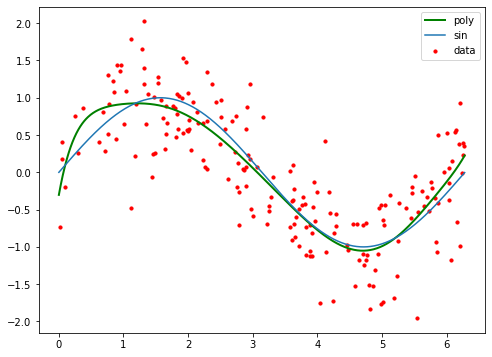

In [9]:
'''
Now that we have attained @w that maximize the log-likelihood, let's see the effect.
'''
p = poly.Polynomial(w)
poly_y = p(x)
plt.figure(figsize=(8,6))
plt.plot(x, poly_y, color='green', linewidth=2, label='poly')
plt.plot(x, y, label='sin')
plt.scatter(_x, _y, marker='o', c='red', s=10, label='data')
plt.legend(loc='upper right')
plt.show()

Now instead of learning from the whole dataset, we would like to learn from mini-dataset, which reduces the computation cost. Using the SGD algorithm, we know that for large datasets, the parameter converges to that learned by the whole dataset:

$$
\mathbf{w}^{(\tau+1)} = \mathbf{w}^{(\tau)}-\eta\nabla E_n 
= \mathbf{w}^{(\tau)}+\eta(t_n-\mathbf{w}^{(\tau)T}\phi(\mathbf{x_n}))\phi^T(\mathbf{x_n})
\tag{3.23}
$$

As an extension, the size of minibatch might be greater than 1, one *epoch* of the algorithm should be like this:

$$
\mathbf{w}^{(\tau+1)} 
= \mathbf{w}^{(\tau)}+\frac{\eta}{B}\sum_{n=1}^{B}(t_n-\mathbf{w}^{(\tau)T}\phi(\mathbf{x_n}))\phi^T(\mathbf{x_n})
$$

In [79]:
w_LMS = np.zeros(10)
LR.LMS(w_LMS, data, batch=1, order=10)

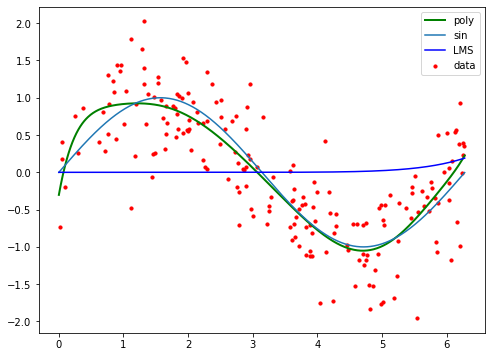

In [80]:
p_LMS = poly.Polynomial(w_LMS)
poly_y_LMS = p_LMS(x)
plt.figure(figsize=(8,6))
plt.plot(x, poly_y, color='green', linewidth=2, label='poly')
plt.plot(x, y, label='sin')
plt.plot(x, poly_y_LMS, color='blue', label='LMS')
plt.scatter(_x, _y, marker='o', c='red', s=10, label='data')
plt.legend(loc='upper right')
plt.show()